### Process
- Loading Data
- Target Input and Output Data
- Count words in text 
- Applying Regular Expression
- Visulization
- Preprocessing text
- WordVector Corpus
- Apply Classification model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn
from nltk.corpus import stopwords
import re
import time
import string
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

Its time to check the data

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Check who is presents and what categories of info they are providing.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.8+ KB


- 'Unnamed: 2','Unnamed: 3','Unnamed: 4' columns contains few numbers then we can eliminate those number as they have lesser contribution to get the info. They are the actual class bunkers, so by eliminating them we will give them punishment.

In [4]:
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
data.head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


- Now there are only two categories in class name 'v1' as grading system and 'v2' as studnets we will work on students to get good results. 
- v1 results are based on v2 so we will try to concentrate on v2 first.

Step 1 : Call these all students from v2 and get them together and count them

In [5]:
data['Count']=0
for i in np.arange(0,len(data.v2)):
    data.loc[i,'Count'] = len(data.loc[i,'v2'])
    
data

,v1,v2,Count
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161
5568,ham,Will Ì_ b going to esplanade fr home?,37
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


Step 2 : Try to reduce these number(students) to get best out of them  
- Only take the first class students, eliminate unwanted onces
- Align inline and check the visuals.

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b','num', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
data['v2'] = data['v2'].apply(lambda x: clean_text(x))
#test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
data['v2'][0]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

In [7]:
import nltk
from nltk.tokenize import word_tokenize
reviews = data.v2.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10]

8230


['to', 'i', 'you', 'a', 'the', 'u', 'and', 'is', 'in', 'me']

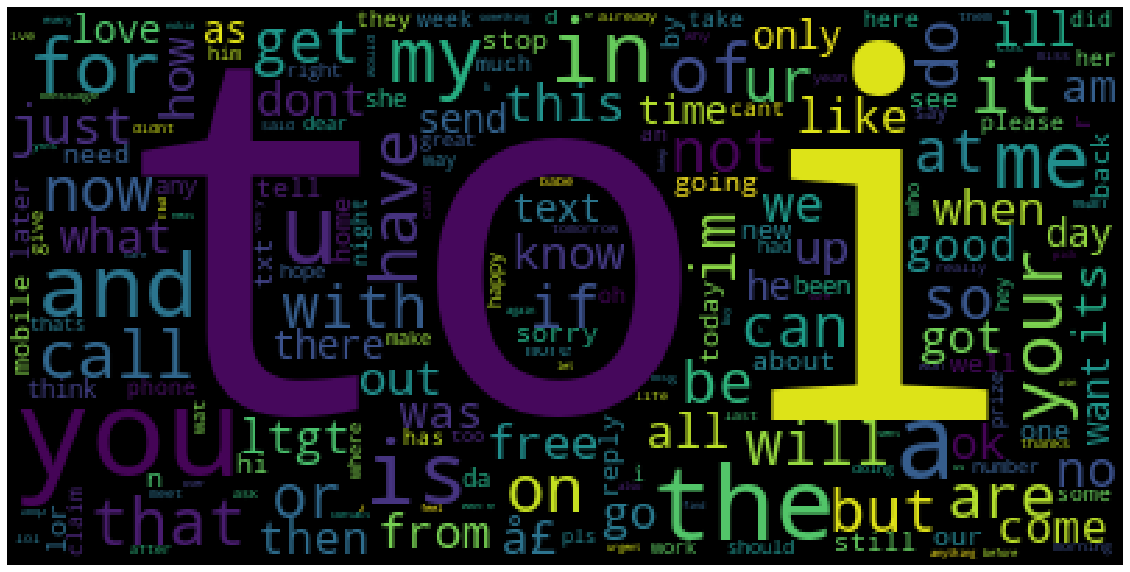

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Step 3 : Work on the v1 results to get proper grade system.

In [9]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["v1"] = lb_make.fit_transform(data["v1"])
data.head()

,v1,v2,Count
0,0,go until jurong point crazy available only in ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry in a wkly comp to win fa cup final...,155
3,0,u dun say so early hor u c already then say,49
4,0,nah i dont think he goes to usf he lives aroun...,61


In [10]:
corpus =  []
for i in data['v2']:
    #print(i)
    corpus.append(i)
results = data['v1']

In [11]:
cv = CountVectorizer()
x = cv.fit_transform(corpus).toarray()

In [12]:
le = LabelEncoder()
results = le.fit_transform(results)
y = results

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y,test_size= 0.20, random_state = 0)

In [14]:
bayes_classifier = GaussianNB()
bayes_classifier.fit(xtrain, ytrain)

GaussianNB(priors=None, var_smoothing=1e-09)

In [15]:
y_pred = bayes_classifier.predict(xtest)

In [16]:
cm = confusion_matrix(ytest, y_pred)
cm

array([[848, 101],
       [ 26, 140]])

In [17]:
print ("Accuracy : %0.5f \n\n" % accuracy_score(ytest, bayes_classifier.predict(xtest)))
print (classification_report(ytest, bayes_classifier.predict(xtest)))

Accuracy : 0.88610 


              precision    recall  f1-score   support

           0       0.97      0.89      0.93       949
           1       0.58      0.84      0.69       166

    accuracy                           0.89      1115
   macro avg       0.78      0.87      0.81      1115
weighted avg       0.91      0.89      0.89      1115



In [18]:
dt = DecisionTreeClassifier(random_state=50)
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=50, splitter='best')

In [19]:
y_pred_dt = dt.predict(xtest)

In [20]:
# Evaluating
cm = confusion_matrix(ytest, y_pred_dt)

print(cm)

[[929  20]
 [ 26 140]]


In [21]:
print ("Accuracy : %0.5f \n\n" % accuracy_score(ytest, dt.predict(xtest)))
print (classification_report(ytest, dt.predict(xtest)))

Accuracy : 0.95874 


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       949
           1       0.88      0.84      0.86       166

    accuracy                           0.96      1115
   macro avg       0.92      0.91      0.92      1115
weighted avg       0.96      0.96      0.96      1115



Results are good and now everyone is happy